# Project 2 part 3
Running a bunch of models on different datasets

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold

from copy import deepcopy

import statistics
import numpy as np
import pandas as pd

In [75]:
kf = KFold(10,shuffle=True,random_state=8)

In [76]:
engineered = pd.read_pickle('engineerd.pkl')
basic = pd.read_pickle('eng_no_com.pkl')
test = pd.read_pickle('whole_test.pkl')

In [4]:
#get features
X_eng = engineered.iloc[:,1:]
X_base = basic.iloc[:,1:]
X_test = test.iloc[:,1:]
#get dependent variable
y_test = test.iloc[:,0]
y = engineered.iloc[:,0]

In [ ]:
#getting alphas to run models

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

In [6]:
#determine best alpha for lasso on X_eng data
eng_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
lass_results = eng_Lasso.fit(X_scaled,y)
best_alpha_l_eng = lass_results.alpha_

In [9]:
#determine best alpha for ridge on X_eng data
eng_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
rid_results = eng_Ridge.fit(X_scaled,y)
best_alpha_r_eng = rid_results.alpha_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
def model_competition(feature_matrix,target_series,l_alpha,r_alpha):
    ols = LinearRegression()
    lasso = Lasso(alpha = l_alpha)
    ridge = Ridge(alpha = r_alpha)
    models = {ols:'OLS',lasso:'lasso',ridge:'ridge'}
    for model in models.keys() :
        if model == ols :
            r2 = cross_val_score(model, feature_matrix, target_series,cv=kf, scoring='r2')
            print(f'The mean r2 for {models[model]} is {np.mean(r2)} +- {np.std(r2)}.')
        else :
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(feature_matrix)
            r2 = cross_val_score(model, X_scaled, target_series,cv=kf, scoring='r2')
            print(f'The mean r2 for {models[model]} is {np.mean(r2)} +- {np.std(r2)}.')

In [13]:
#baseline R2
model_competition(feature_matrix=X_eng,
                  target_series=y,
                  l_alpha=best_alpha_l_eng,
                  r_alpha=best_alpha_r_eng)

The mean r2 for OLS is 0.25519105341418247 +- 0.22419681464963265.
The mean r2 for lasso is 0.25824503276186145 +- 0.21949260330742001.
The mean r2 for ridge is 0.2965115396569085 +- 0.1652828930854732.


In [14]:
#what does lasso want us to ditch? Nothing
eng_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

results = eng_Lasso.fit(X_scaled,y)
print(results.alpha_,'\n')
list(zip(X_eng.columns,results.coef_))

0.003981071705534978 



[('happy', 0.282346437148442),
 ('pop_dens', -0.2538802332383614),
 ('avg_temp', -0.5804893016921688),
 ('int_users', -0.34008183515384716),
 ('ling_div', -0.21199742589191864),
 ('alc_cons', 0.5797467592131855),
 ('total_bmi', -0.3523179462728643),
 ('elevation', -0.2465428011120438),
 ('depression', -0.26307899987082184),
 ('t_doc_lit_gdppp', -0.38025183790923917),
 ('t_eth_relig', 0.27853841036694044),
 ('t_imm_urb_d_guns', 0.17032004534424441)]

In [15]:
#but if it had to tell us to ditch something...
eng_Lasso = Lasso(alpha=.06)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

results = eng_Lasso.fit(X_scaled,y)
list(zip(X_eng.columns,results.coef_))

[('happy', 0.036086141723106493),
 ('pop_dens', -0.22116610354350869),
 ('avg_temp', -0.3213097117590453),
 ('int_users', -0.2342775058827606),
 ('ling_div', -0.0),
 ('alc_cons', 0.5669723282643184),
 ('total_bmi', -0.28347033983844416),
 ('elevation', -0.13474378697751016),
 ('depression', -0.20737844079282594),
 ('t_doc_lit_gdppp', -0.08482146063774283),
 ('t_eth_relig', 0.1362524513352522),
 ('t_imm_urb_d_guns', 0.060054311468175456)]

# Oops!
I was an idiot in the next few cells and copy-pasted an alpha - I know this is not best practice, because the best alpha might change based on what I've dropped! I also might have wanted to look at the score for things beyond just lasso - hindsight, eh? For integrity reasons though, I'll leave this as is.

In [17]:
lasso = Lasso(alpha = 0.0006074174456657797)
r2 = cross_val_score(lasso, X_scaled, y,cv=kf, scoring='r2')
np.mean(r2)

0.2557095732945962

In [18]:
eng_drop = X_eng.drop(['ling_div'],axis=1)
X_scaled_d = scaler.fit_transform(X_eng.drop(['ling_div'],axis=1))

lasso = Lasso(alpha = 0.0006074174456657797)
r2 = cross_val_score(lasso, X_scaled_d, y,cv=kf, scoring='r2')
np.mean(r2)
# dropping ling_div increases the r^2

0.2753899446324918

Try dropping the next least important

In [19]:
X_eng = X_eng.drop(['ling_div'],axis=1)
eng_Lasso = Lasso(alpha=.08)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

results = eng_Lasso.fit(X_scaled,y)
list(zip(X_eng.columns,results.coef_))

[('happy', 0.0),
 ('pop_dens', -0.21107740909479386),
 ('avg_temp', -0.24891571625820966),
 ('int_users', -0.198950547203549),
 ('alc_cons', 0.5478068659894972),
 ('total_bmi', -0.28293287665723926),
 ('elevation', -0.0948290430203321),
 ('depression', -0.195127013096021),
 ('t_doc_lit_gdppp', -0.0174850644158335),
 ('t_eth_relig', 0.13010467647044327),
 ('t_imm_urb_d_guns', 0.032257375666422776)]

In [20]:
eng_drop = X_eng.drop(['happy'],axis=1)
X_scaled_d = scaler.fit_transform(X_eng.drop(['happy'],axis=1))

lasso = Lasso(alpha = 0.0006074174456657797)
r2 = cross_val_score(lasso, X_scaled_d, y,cv=kf, scoring='r2')
np.mean(r2)

0.2488799032577135

In [21]:
#based on this we should ONLY get rid of ling_div

In [22]:
X_eng.columns

Index(['happy', 'pop_dens', 'avg_temp', 'int_users', 'alc_cons', 'total_bmi',
       'elevation', 'depression', 't_doc_lit_gdppp', 't_eth_relig',
       't_imm_urb_d_guns'],
      dtype='object')

In [23]:
model_competition(feature_matrix=X_eng,
                  target_series=y,
                  l_alpha=best_alpha_l_eng,
                  r_alpha=best_alpha_r_eng)
#Now the best is ridge!

The mean r2 for OLS is 0.2751671024768134 +- 0.2403214553824235.
The mean r2 for lasso is 0.2764059232808285 +- 0.23691214036446231.
The mean r2 for ridge is 0.30140452777395665 +- 0.17677850034655115.


# Okay! 
So our best model on our engineered data is ridge, with an $R^2$ of .30; let's see how the base data compares.

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)

In [25]:
base_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
lass_results = base_Lasso.fit(X_scaled,y)

In [26]:
best_alpha_l_base = lass_results.alpha_

In [27]:
base_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
rid_results = base_Ridge.fit(X_scaled,y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
best_alpha_r_base = rid_results.alpha_

In [29]:
model_competition(X_base,y,best_alpha_l_base,best_alpha_r_base)

The mean r2 for OLS is 0.06247150739912292 +- 0.306955533530708.
The mean r2 for lasso is 0.25814124315861886 +- 0.1885207730664019.
The mean r2 for ridge is 0.25940152390347154 +- 0.12482155754575412.


# Hmmm...
Those are not great. Let's check out the lasso, see if we should remove anything (spoliers : yeah).

In [30]:
base_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)

results = base_Lasso.fit(X_scaled,y)
results.alpha_
list(zip(X_base.columns,results.coef_))

[('happy', 0.0),
 ('doc_ratio', -0.16731806376620642),
 ('below_pov_line', 0.0),
 ('gdp', 0.0),
 ('unemp', -0.0018901273183582388),
 ('med_age', 0.0),
 ('homeless_dummy', 0.0),
 ('total_sex_ratio', 0.1270870934988941),
 ('hum_freedom', 0.012052198728099445),
 ('econ_freedom', 0.0),
 ('gen_inequality', 0.0),
 ('sunny_hours', -0.2099570022796794),
 ('pop_dens', -0.2405089445896324),
 ('avg_temp', -0.2589096192294321),
 ('eth_div', 0.08798260855819676),
 ('int_users', -0.19472286411830464),
 ('ling_div', 0.0),
 ('relig_div', 0.0),
 ('alc_cons', 0.49111904728491246),
 ('total_bmi', -0.18458862479710153),
 ('r_home_war', -0.07379165659032588),
 ('elevation', -0.11980703685046928),
 ('depression', -0.22715103721349272),
 ('children', 0.0),
 ('marr_div_dummy', 0.0),
 ('urbanization', 0.009379332047049042),
 ('immigrants', -0.0),
 ('malnutrition_dummy', 0.0),
 ('pov_ind_dummy', -0.0),
 ('guns', -0.0030518915240961577),
 ('gdppp', -0.0),
 ('literacy', -0.09599347425354215),
 ('population', 0.03

In [31]:
base_dropping = X_base.drop(['happy','below_pov_line','gdp','unemp','med_age','homeless_dummy','hum_freedom',
                             'econ_freedom','gen_inequality','ling_div','relig_div','children','marr_div_dummy',
                            'urbanization','immigrants','malnutrition_dummy','pov_ind_dummy','guns','gdppp'],axis=1)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_dropping)

In [33]:
base_d_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
lass_results = base_d_Lasso.fit(X_scaled,y)

In [34]:
best_alpha_l_base_d = lass_results.alpha_

In [35]:
base_d_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
rid_results = base_d_Ridge.fit(X_scaled,y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [36]:
best_alpha_r_base_d = rid_results.alpha_

In [37]:
model_competition(base_dropping,y,best_alpha_l_base_d,best_alpha_r_base_d)

The mean r2 for OLS is 0.2545426327528808 +- 0.24444615954360793.
The mean r2 for lasso is 0.2735783981987078 +- 0.21363229451441287.
The mean r2 for ridge is 0.3209667624224735 +- 0.1426613279268113.


# Much better
Ridge is still our best model it seems. Let's see what the first thing lasso wants us to get rid of is.

In [38]:
base_Lasso = Lasso(alpha = .07)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_dropping)

results = base_Lasso.fit(X_scaled,y)
list(zip(base_dropping.columns,results.coef_))

[('doc_ratio', -0.1400852025306447),
 ('total_sex_ratio', 0.12185906181293972),
 ('sunny_hours', -0.1913112044882556),
 ('pop_dens', -0.2316632115722695),
 ('avg_temp', -0.21463235753821872),
 ('eth_div', 0.07476090924569674),
 ('int_users', -0.1452453359715917),
 ('alc_cons', 0.4830221876071897),
 ('total_bmi', -0.21041924835827427),
 ('r_home_war', -0.04264031988608),
 ('elevation', -0.08418091520490535),
 ('depression', -0.21599579816874992),
 ('literacy', -0.07918138880738314),
 ('population', 0.0)]

In [39]:
X_base_dropping_2 = X_base.drop(['population'],axis=1)

In [40]:
base_d_Lasso = LassoCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
lass_results = base_d_Lasso.fit(X_scaled,y)
best_alpha_l_base_d_2 = lass_results.alpha_

In [41]:
base_d_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
ridge_results = base_d_Ridge.fit(X_scaled,y)
best_alpha_r_base_d_2 = ridge_results.alpha_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
model_competition(X_base_dropping_2,y,best_alpha_l_base,best_alpha_r_base)

The mean r2 for OLS is 0.08900102027380362 +- 0.2999126888183398.
The mean r2 for lasso is 0.2620450110383634 +- 0.19282391817830027.
The mean r2 for ridge is 0.26361915506930933 +- 0.12541454961687704.


# Nope!
Extra dropping hurts us. So our best model is ridge, whether we use the base data or the engineered, though our base is slightly better. So we will continue working with these two.

<br />
But first! Let's look at the importance of our base variables (for fun).


In [43]:
base_Lasso_imp = Lasso(alpha=best_alpha_l_base_d)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_dropping)

results = base_Lasso_imp.fit(X_scaled,y)
list(zip(base_dropping.columns,results.coef_))

[('doc_ratio', -0.2037431909733826),
 ('total_sex_ratio', 0.13719666317006035),
 ('sunny_hours', -0.24184994481218813),
 ('pop_dens', -0.25394115310775955),
 ('avg_temp', -0.31929136413453624),
 ('eth_div', 0.10544301551813894),
 ('int_users', -0.240584975850209),
 ('alc_cons', 0.5008340113258628),
 ('total_bmi', -0.14787969874066478),
 ('r_home_war', -0.13168609481391766),
 ('elevation', -0.1716840369603773),
 ('depression', -0.2452060401111569),
 ('literacy', -0.12030039518887438),
 ('population', 0.08077898031390905)]

In [44]:
list(zip(base_dropping.columns,(abs(results.coef_)/np.sum(abs(results.coef_)))))

[('doc_ratio', 0.07024610971133921),
 ('total_sex_ratio', 0.04730235060632174),
 ('sunny_hours', 0.08338446882957565),
 ('pop_dens', 0.08755324787154288),
 ('avg_temp', 0.11008454362437052),
 ('eth_div', 0.036354400856268565),
 ('int_users', 0.08294833573447637),
 ('alc_cons', 0.17267640080969804),
 ('total_bmi', 0.0509856230884969),
 ('r_home_war', 0.04540242949745875),
 ('elevation', 0.05919282817937135),
 ('depression', 0.0845415756631673),
 ('literacy', 0.041476894115490416),
 ('population', 0.027850791412422127)]

### Cool.
Now onto more stuff.

In [45]:
base_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_dropping)

results = base_Ridge.fit(X_scaled,y)
results.alpha_

print(
    np.mean(
        cross_val_score(
            base_Ridge,base_dropping,y,cv=kf)
    ))

list(zip(base_dropping.columns,results.coef_))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

0.31401392350164653


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[('doc_ratio', -0.15682887403575574),
 ('total_sex_ratio', 0.16649388819623429),
 ('sunny_hours', -0.21621189365477939),
 ('pop_dens', -0.23148536636658898),
 ('avg_temp', -0.23966532112495176),
 ('eth_div', 0.1101323471201384),
 ('int_users', -0.1434023156226654),
 ('alc_cons', 0.37879598666846376),
 ('total_bmi', -0.1536175514772113),
 ('r_home_war', -0.13167665292694813),
 ('elevation', -0.12753408058379728),
 ('depression', -0.21608034491173672),
 ('literacy', -0.11105529495095204),
 ('population', 0.0857001114462591)]

In [46]:
eng_Ridge = RidgeCV(alphas = 10**np.linspace(-10,10,1001),cv = kf)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

results = eng_Ridge.fit(X_scaled,y)
results.alpha_

print(np.mean(cross_val_score(eng_Ridge,X_eng,y,cv=kf)))


list(zip(X_eng.columns,results.coef_))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

0.31961484313194743


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[('happy', 0.1497597731823567),
 ('pop_dens', -0.24074361062573188),
 ('avg_temp', -0.39913177448837844),
 ('int_users', -0.2455565188146855),
 ('alc_cons', 0.5157961953303313),
 ('total_bmi', -0.29094950011185466),
 ('elevation', -0.17732004888539232),
 ('depression', -0.2362876138198426),
 ('t_doc_lit_gdppp', -0.18216647132022573),
 ('t_eth_relig', 0.1663823728641938),
 ('t_imm_urb_d_guns', 0.10451726500223654)]

# Well
Honestly, at some point you have to just test the model. We can't drop anything else, and my best shot at engineering is already there. Let's make sure these models work-ish (spoiler alert...).
<br />

But first, we need to transform our test data as well!

In [47]:
X_test['gdp'] = np.log(X_test.gdp)
X_test['total_sex_ratio'] = 1/(X_test.total_sex_ratio)
X_test['guns'] = np.log(X_test.guns+1)
X_test['doc_ratio'] = np.log(X_test.doc_ratio)
X_test['pop_dens'] = np.log(X_test.pop_dens)
X_test['elevation'] = np.log(X_test.elevation)
X_test['immigrants'] = np.log(X_test.immigrants)
X_test['literacy'] = (X_test.literacy)**1/2
X_test['gdppp'] = np.log(X_test.gdppp)
X_test['population'] = np.log(X_test.population)
X_test['children'] = X_test.children**2

In [48]:
X_test_drop = X_test.drop(['happy','below_pov_line','gdp','unemp','med_age','homeless_dummy','hum_freedom',
                             'econ_freedom','gen_inequality','ling_div','relig_div','children','marr_div_dummy',
                            'urbanization','immigrants','malnutrition_dummy','pov_ind_dummy','guns','gdppp'],axis=1)

In [49]:
X_test_eng = deepcopy(X_test)

X_test_eng['t_doc_lit_gdppp'] = X_test_eng.doc_ratio * X_test_eng.literacy * X_test_eng.gdppp
X_test_eng = X_test_eng.drop(['doc_ratio','literacy','gdppp'],axis=1)

X_test_eng['t_eth_relig'] = X_test_eng.eth_div * X_test_eng.relig_div
X_test_eng = X_test_eng.drop(['eth_div','relig_div'],axis=1)

X_test_eng['t_imm_urb_d_guns'] = X_test_eng.immigrants * X_test_eng.urbanization / X_test_eng.guns
X_test_eng = X_test_eng.drop(['immigrants','urbanization','guns'],axis=1)

X_test_eng = X_test_eng.drop(['below_pov_line','gdp','unemp','med_age','homeless_dummy','total_sex_ratio','hum_freedom',
                             'econ_freedom','gen_inequality','sunny_hours','ling_div','r_home_war','children',
                              'marr_div_dummy','malnutrition_dummy','pov_ind_dummy','population'],axis = 1)

# Now let's compare!

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_dropping)
X_test_scaled = scaler.transform(X_test_drop)

lm_reg = Ridge()
results = lm_reg.fit(base_dropping,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled,y_test)}')

Ridge Regression test R^2: -19.960857614823624


In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)
X_test_scaled = scaler.transform(X_test_eng)

lm_reg = Ridge()
results = lm_reg.fit(X_eng,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled,y_test)}')

Ridge Regression test R^2: -29.8546086024878


# Oof
Lara was't kidding when she said that ridge and lasso had some issues with small amounts of data. Let's try our best OLS, which was on our engineered data.

In [52]:
lm_ols = LinearRegression()
results = lm_ols.fit(X_eng,y)
print(f'OLS test R^2: {lm_ols.score(X_test_eng,y_test)}')

OLS test R^2: 0.2527086546444801


# Whew
It is indeed the case that Ridge does not work well on small data sets I guess; so we will have to go for naïve OLS

In [53]:
lm_ols = LinearRegression()
results = lm_ols.fit(X_eng,y)

predict = lm_ols.predict(X_test_eng)

In [54]:
list(zip(lm_ols.coef_,X_test_eng.columns))

[(0.24222774295707017, 'happy'),
 (-0.17864822298363942, 'pop_dens'),
 (-0.06409267574018249, 'avg_temp'),
 (-0.0136435400718852, 'int_users'),
 (0.14814503842142418, 'alc_cons'),
 (-0.14553730316598146, 'total_bmi'),
 (-0.23974734869723272, 'elevation'),
 (-0.0014140238550069335, 'depression'),
 (-0.00044929403478437057, 't_doc_lit_gdppp'),
 (0.8855180216740928, 't_eth_relig'),
 (0.00019376658034216622, 't_imm_urb_d_guns')]

In [55]:
np.mean(abs(y_test-predict))

0.9714996586827394

In [56]:
np.max(abs(y_test-predict))

2.965292496171334

In [57]:
np.min(abs(y_test-predict))

0.11218844602733746

# But that's predicting our boxcox transformed data!
Let's undo that, so we can better understand what that means.

<br />
From our data scraping notebook : boxcox lambda ≈ 0.41719220590443856

In [58]:
from scipy.special import inv_boxcox

In [59]:
inv_bc_pred = inv_boxcox(predict,[.41719220590443856])

In [60]:
inv_bc_y_test = inv_boxcox(y_test,[.41719220590443856])

In [61]:
inv_bc_pred

array([ 7.07744439, 11.62096505, 14.42355371,  3.06223026, 14.01290912,
       14.07331956, 11.1018197 , 10.17335189,  9.78729161,  9.59725403,
        9.88564968, 14.3472517 , 16.3471387 ,  5.84110463, 10.16058584,
        7.53811674, 10.62709033,  8.12041643, 16.57488566,  4.25630135,
       12.41586239, 14.21221013,  6.97644886, 14.3729292 ,  3.00266905,
        2.51849795,  3.11863454,  5.23993311,  5.79983348, 10.78785686,
       11.5995968 ,  7.40111513,  5.730678  ,  5.16289239, 11.02794931,
       11.07676869,  8.53334449])

In [62]:
np.mean(abs((inv_bc_pred-inv_bc_y_test)))

3.635518736228865

In [63]:
np.mean((inv_bc_pred-inv_bc_y_test))

-0.15929997921059755

In [64]:
np.max(abs(inv_bc_y_test-inv_bc_pred))

12.212708385637223

In [65]:
np.min(abs(inv_bc_y_test-inv_bc_pred))

0.25630134857294085

In [66]:
np.std(abs(inv_bc_y_test-inv_bc_pred))

2.9762999664611316

In [67]:
np.median(abs(inv_bc_y_test-inv_bc_pred))

2.7377697405637877

In [68]:
base_Lasso_imp = Lasso(alpha=best_alpha_l_eng)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

results = base_Lasso_imp.fit(X_scaled,y)
list(zip(X_eng.columns,results.coef_))

[('happy', 0.253730358097335),
 ('pop_dens', -0.24593040381382586),
 ('avg_temp', -0.5348957981063442),
 ('int_users', -0.3609558297149362),
 ('alc_cons', 0.61224827780143),
 ('total_bmi', -0.30946562046403253),
 ('elevation', -0.23311909920348692),
 ('depression', -0.26512751832909215),
 ('t_doc_lit_gdppp', -0.3023016839215555),
 ('t_eth_relig', 0.15758527132781203),
 ('t_imm_urb_d_guns', 0.14053937956703513)]

In [69]:
#% contribution of each variable
importances = list(zip(X_eng.columns,(abs(results.coef_)/np.sum(abs(results.coef_)))))

In [70]:
#to df
pd.DataFrame(importances).sort_values(by=1,ascending=False)

,0,1
4,alc_cons,0.179235
2,avg_temp,0.156590
3,int_users,0.105669
5,total_bmi,0.090596
8,t_doc_lit_gdppp,0.088498
7,depression,0.077616
0,happy,0.074279
1,pop_dens,0.071996
6,elevation,0.068245
9,t_eth_relig,0.046133


In [77]:
#plot residuals! bad news
import seaborn as sns
import matplotlib.pyplot as plt

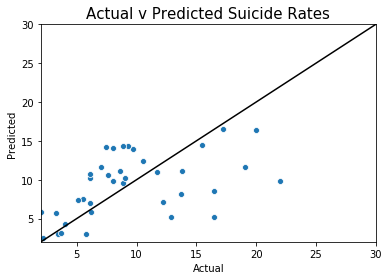

In [72]:
sns.scatterplot(inv_bc_y_test,inv_bc_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual v Predicted Suicide Rates',fontdict = {'size':15})
plt.xlim(2,30)
plt.ylim(2,30)
plt.plot([2,30],[2,30],color='k');

(array([4., 6., 7., 9., 1., 3., 2., 3., 0., 2.]),
 array([-6.81221013, -4.90971828, -3.00722642, -1.10473457,  0.79775728,
         2.70024913,  4.60274098,  6.50523283,  8.40772468, 10.31021653,
        12.21270839]),
 <a list of 10 Patch objects>)

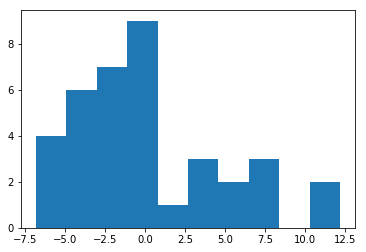

In [73]:
# look at distribution of errors.. not good
plt.hist(inv_bc_y_test-inv_bc_pred)